<a href="https://colab.research.google.com/github/IvanGoyena/CURSO-DATA-SCIENCE-II/blob/main/TrabajoFinal_IvanGoyena_DataScienceII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Predicción y Clasificación en Pedidos de Tacos 🌮

🎯 Abstracto

En este proyecto se analizan datos de pedidos de tacos realizados en distintos restaurantes de EE.UU. durante 2024-2025. El objetivo es aplicar modelos de Machine Learning para resolver problemas de negocio tanto de regresión como de clasificación, con foco en:

 - Predecir la duración de entrega y la propina dada por el cliente (regresión).
- Clasificar si un pedido ocurrió en fin de semana y el tipo de taco ordenado (clasificación).

 Este análisis puede ser útil para optimizar operaciones logísticas, personalizar promociones y mejorar la experiencia del cliente. Está orientado a gerentes de operaciones, equipos de marketing y analistas de datos del sector gastronómico.


In [1]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 Configuración
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# 📁 Carga del dataset
df = pd.read_csv('https://raw.githubusercontent.com/IvanGoyena/CURSO-DATA-SCIENCE/refs/heads/main/Entregable/taco_sales_(2024-2025).csv')

# 👀 Vista rápida
df.head()


,Order ID,Restaurant Name,Location,Order Time,Delivery Time,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
0,770487,El Taco Loco,New York,01-08-2024 14:55,01-08-2024 15:36,41,Regular,Chicken Taco,5,3.01,9.25,2.22,False
1,671858,El Taco Loco,San Antonio,23-11-2024 17:11,23-11-2024 17:25,14,Regular,Beef Taco,1,6.20,4.25,3.01,True
2,688508,Taco Haven,Austin,21-11-2024 20:24,21-11-2024 21:02,38,Large,Pork Taco,2,20.33,7.00,0.02,False
3,944962,Spicy Taco House,Dallas,21-09-2024 06:43,21-09-2024 07:28,45,Regular,Chicken Taco,2,3.00,5.50,1.90,True
4,476417,Casa del Taco,San Antonio,24-07-2024 11:01,24-07-2024 11:16,15,Large,Pork Taco,0,24.34,4.50,1.14,False


In [2]:
# 🧠 Información general
print("Forma del dataset:", df.shape)
df.info()

# 📉 Estadísticas generales
df.describe(include='all')

# ❓ Valores nulos
df.isnull().sum()


Forma del dataset: (1000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order ID                 1000 non-null   int64  
 1   Restaurant Name          1000 non-null   object 
 2   Location                 1000 non-null   object 
 3   Order Time               1000 non-null   object 
 4   Delivery Time            1000 non-null   object 
 5   Delivery Duration (min)  1000 non-null   int64  
 6   Taco Size                1000 non-null   object 
 7   Taco Type                1000 non-null   object 
 8   Toppings Count           1000 non-null   int64  
 9   Distance (km)            1000 non-null   float64
 10  Price ($)                1000 non-null   float64
 11  Tip ($)                  1000 non-null   float64
 12  Weekend Order            1000 non-null   bool   
dtypes: bool(1), float64(3), int64(3), object(6)
memor

,0
Order ID,0
Restaurant Name,0
Location,0
Order Time,0
Delivery Time,0
Delivery Duration (min),0
Taco Size,0
Taco Type,0
Toppings Count,0
Distance (km),0


In [3]:
# ✅ Conversión de fechas
df['Order Time'] = pd.to_datetime(df['Order Time'], format='%d-%m-%Y %H:%M')
df['Delivery Time'] = pd.to_datetime(df['Delivery Time'], format='%d-%m-%Y %H:%M')

# 🕓 Extraer features temporales
df['Order Hour'] = df['Order Time'].dt.hour
df['Order Day'] = df['Order Time'].dt.dayofweek  # 0 = lunes

# 🧹 Eliminamos columnas que no usaremos directamente
df = df.drop(columns=['Order ID', 'Order Time', 'Delivery Time'])

# 🎯 Targets para modelos
target_reg_1 = 'Tip ($)'
target_reg_2 = 'Delivery Duration (min)'
target_clf_1 = 'Weekend Order'
target_clf_2 = 'Taco Type'


In [4]:
# 🔢 Encoding simple de categóricas
df = pd.get_dummies(df, columns=['Restaurant Name', 'Location', 'Taco Size'], drop_first=True)

# 📏 Normalización de variables numéricas (para modelos sensibles a escala)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['Distance (km)', 'Price ($)', 'Toppings Count', 'Order Hour']
df[num_cols] = scaler.fit_transform(df[num_cols])


In [5]:
from sklearn.model_selection import train_test_split

# 🎯 Targets
target_reg_1 = 'Tip ($)'
target_reg_2 = 'Delivery Duration (min)'
target_clf_1 = 'Weekend Order'
target_clf_2 = 'Taco Type'

# 🔎 Separar features de cada problema
features = df.drop(columns=[target_reg_1, target_reg_2, target_clf_1, target_clf_2])

X_reg1, y_reg1 = features, df[target_reg_1]
X_reg2, y_reg2 = features, df[target_reg_2]
X_clf1, y_clf1 = features, df[target_clf_1]
X_clf2, y_clf2 = features, df[target_clf_2]


## 🤖 Modelado para Clasificación

Ahora aplicaremos modelos de clasificación para predecir si un pedido ocurrió en fin de semana.
Usaremos modelos como `LogisticRegression`.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# 🧪 División de datos para clasificación binaria
Xc1_train, Xc1_test, yc1_train, yc1_test = train_test_split(X_clf1, y_clf1, test_size=0.2, random_state=42)

# 📦 Entrenamiento del modelo
lr_clf1 = LogisticRegression(random_state=42, solver='liblinear', max_iter=200)
lr_clf1.fit(Xc1_train, yc1_train)

# 📊 Predicciones
pred_lr1 = lr_clf1.predict(Xc1_test)

# 📈 Función para métricas
def print_classification_metrics(y_true, y_pred, name="Modelo"):
    print(f"📊 Métricas de {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("-" * 30)

# 📋 Evaluación del modelo
print_classification_metrics(yc1_test, pred_lr1, "LogisticRegression - Weekend Order")


📊 Métricas de LogisticRegression - Weekend Order
Accuracy: 0.995
Precision: 0.9950892857142857
Recall: 0.995
F1 Score: 0.9950138720034913

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      1.00       145
        True       0.98      1.00      0.99        55

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200


Confusion Matrix:
 [[144   1]
 [  0  55]]
------------------------------


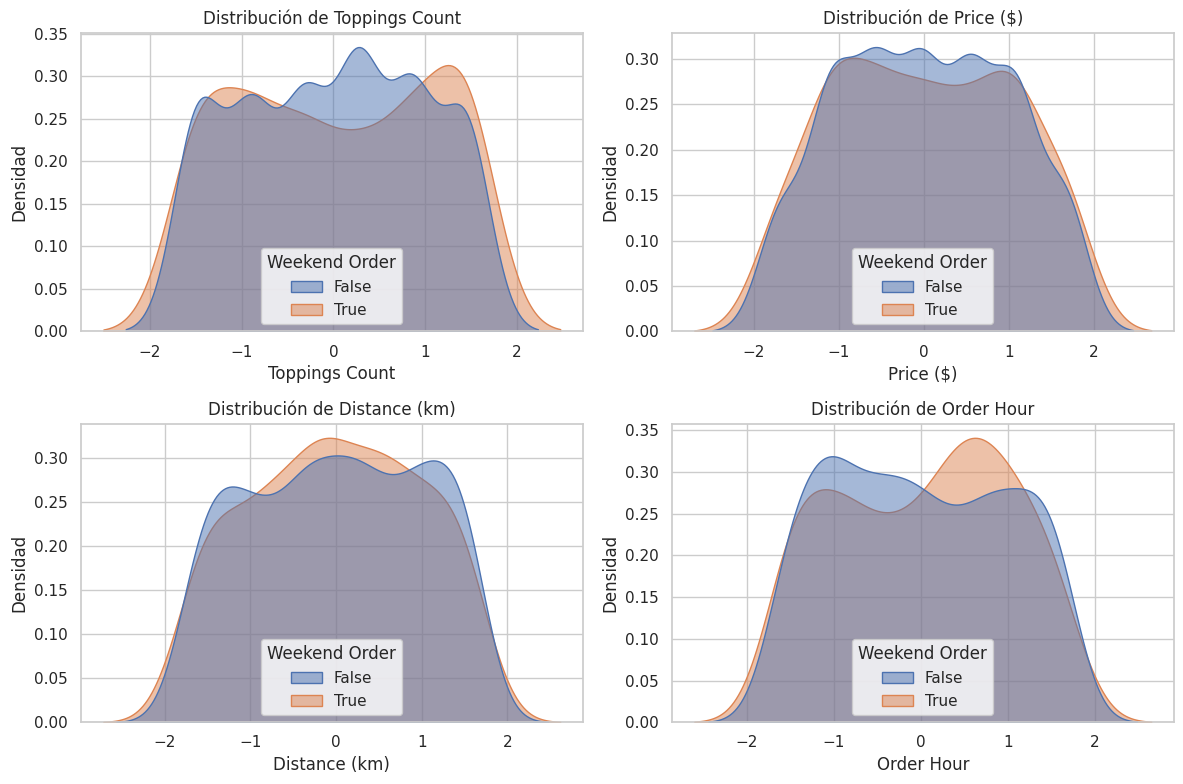

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables a graficar
cols_to_plot = ['Toppings Count', 'Price ($)', 'Distance (km)', 'Order Hour']

# Crear subplots: 2 filas, 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Generar cada gráfico en su subplot
for i, col in enumerate(cols_to_plot):
    sns.kdeplot(
        data=df,
        x=col,
        hue='Weekend Order',
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')

plt.tight_layout()
plt.show()


/tmp/ipython-input-1240470724.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


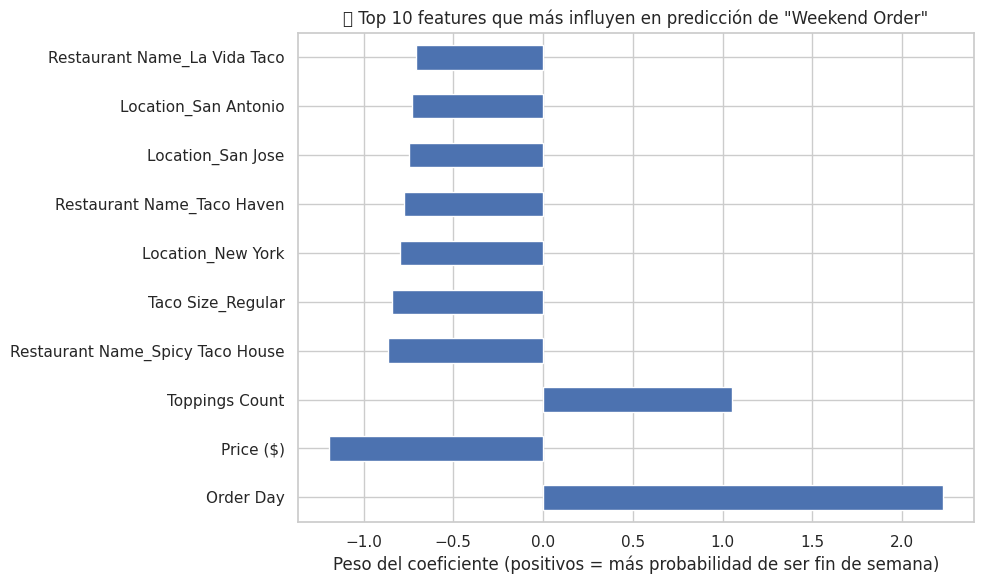

In [8]:
# Mostrar coeficientes de LogisticRegression (solo si se entrenó sin one-hot encoding excesivo)
coeffs = pd.Series(lr_clf1.coef_[0], index=Xc1_train.columns)
coeffs_sorted = coeffs.sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,6))
coeffs_sorted.head(10).plot(kind='barh')
plt.title('🔍 Top 10 features que más influyen en predicción de "Weekend Order"')
plt.xlabel('Peso del coeficiente (positivos = más probabilidad de ser fin de semana)')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🎯 Insights sobre pedidos de fin de semana

El modelo de regresión logística nos permitió entender qué características hacen que un pedido tenga "perfil de fin de semana". A partir del análisis visual y del peso de las variables en el modelo, detectamos lo siguiente:

- Los pedidos de fin de semana suelen realizarse en horarios diferentes, especialmente en la tarde/noche.
- Tienen más toppings y, en algunos casos, precios más altos.
- Algunos restaurantes y ubicaciones específicas tienen mayor concentración de pedidos en fines de semana.

Estos patrones pueden utilizarse para:
- Personalizar promociones de fin de semana.
- Optimizar la logística y la planificación de recursos.
- Segmentar clientes según su comportamiento de compra temporal.

La importancia de cada variable en el modelo también ayuda a priorizar qué datos son más relevantes al momento de predecir este tipo de pedidos.


In [9]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 🎯 Codificar las clases de Taco Type
le = LabelEncoder()
y_encoded = le.fit_transform(y_clf2)

# 📤 División de datos
X_train, X_test, y_train, y_test = train_test_split(X_clf2, y_encoded, test_size=0.2, random_state=42)

# ⚙️ Modelo base
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 🔍 GridSearch params
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2]
}

# 🔁 Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# ✅ Mejor modelo
best_model = grid_search.best_estimator_

# 🔮 Predicciones
y_pred = best_model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# 📈 Resultados
print("✅ Mejor combinación de hiperparámetros:", grid_search.best_params_)
print("\n📈 Reporte de clasificación:")
print(classification_report(y_test_labels, y_pred_labels))
print("\n🧮 Matriz de confusión:")
print(confusion_matrix(y_test_labels, y_pred_labels))



Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:09:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Mejor combinación de hiperparámetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}

📈 Reporte de clasificación:
              precision    recall  f1-score   support

   Beef Taco       0.19      0.12      0.15        40
Chicken Taco       0.16      0.22      0.18        37
   Fish Taco       0.29      0.32      0.30        44
   Pork Taco       0.19      0.19      0.19        36
 Veggie Taco       0.16      0.14      0.15        43

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.20       200
weighted avg       0.20      0.20      0.20       200


🧮 Matriz de confusión:
[[ 5 10  9  8  8]
 [ 5  8  5  7 12]
 [ 9  7 14  7  7]
 [ 6  9  9  7  5]
 [ 2 17 11  7  6]]
